In [1]:
import torch
import sys
import pathlib 
import joblib
import pandas as pd
import numpy as np
import json
import optuna
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from pathlib import Path
script_directory = pathlib.Path("../2.train-VAE/utils/").resolve()
sys.path.insert(0, str(script_directory))
from betatcvae import BetaTCVAE, compile_tc_vae, tc_weights, extract_latent_dimensions
from optimize_utils_tcvae import get_optimizer_tc

script_directory = pathlib.Path("../utils/").resolve()
sys.path.insert(0, str(script_directory))
from data_loader import load_train_test_data

In [2]:
# Load data
data_directory = pathlib.Path("../0.data-download/data").resolve()
train_data, test_data, val_data, load_gene_stats = load_train_test_data(
    data_directory, train_or_test="all", load_gene_stats=True, zero_one_normalize=True
)

train_tensor = torch.tensor(train_data, dtype=torch.float32)
val_tensor = torch.tensor(val_data, dtype=torch.float32)
test_tensor = torch.tensor(test_data, dtype=torch.float32)

In [3]:
# Load the best hyperparameters
study_name = "BetaTCVAE-Optimization"
storage_name = f"sqlite:///./{study_name}.db"
study = optuna.load_study(study_name=study_name, storage=storage_name)
best_trial = study.best_trial

latent_dim = best_trial.params['latent_dim']
beta = best_trial.params['beta']
learning_rate = best_trial.params['learning_rate']
batch_size = best_trial.params['batch_size']
epochs = best_trial.params['epochs']
optimizer = best_trial.params['optimizer_type']

# Create DataLoader
train_loader = DataLoader(TensorDataset(train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(val_tensor), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(test_tensor), batch_size=batch_size, shuffle=False)

In [4]:
#Initialize the model and optimizer
model = BetaTCVAE(input_dim=train_data.shape[1], latent_dim=latent_dim, beta=beta)
optimizer = get_optimizer_tc(optimizer, model.parameters(), learning_rate)

# Training model
train_loss_history, val_loss_history, test_loss_history = compile_tc_vae(model, train_loader, val_loader, test_loader, optimizer, epochs)

Epoch 1, Train Loss: 189.02626019378206, Val Loss: 37.40689171685113, Test Loss: 35.77649815877279
Epoch 2, Train Loss: 31.873875222277285, Val Loss: 32.21293830871582, Test Loss: 29.42218526204427
Epoch 3, Train Loss: 28.119844351241838, Val Loss: 34.39549297756619, Test Loss: 31.312495973375107
Epoch 4, Train Loss: 27.634110635785913, Val Loss: 32.450671937730576, Test Loss: 30.332862854003906
Epoch 5, Train Loss: 30.4865698059993, Val Loss: 26.772859785291885, Test Loss: 24.971044540405273
Epoch 6, Train Loss: 28.404091997288948, Val Loss: 27.493460125393337, Test Loss: 24.64341206020779
Epoch 7, Train Loss: 26.374176480876866, Val Loss: 29.23808945549859, Test Loss: 26.902609719170464
Epoch 8, Train Loss: 28.300853717860893, Val Loss: 32.159387800428604, Test Loss: 30.935444513956707
Epoch 9, Train Loss: 26.11030933892549, Val Loss: 29.164668824937607, Test Loss: 26.533634821573894
Epoch 10, Train Loss: 27.44485783363456, Val Loss: 25.89885648091634, Test Loss: 22.99789259168837
Ep

In [5]:
# Save the model
model_path = pathlib.Path("results/best_tc_vae_model.pth")
torch.save(model.state_dict(), model_path)

In [6]:
# Save training history
history = {
    'loss': train_loss_history,
    'val_loss': val_loss_history,
    'test_loss': test_loss_history
}

# Convert the history dictionary into a DataFrame
history_df = pd.DataFrame(history)

# Define the path for the parquet file
history_path = pathlib.Path("results/tc_training_history.parquet")

# Save the DataFrame to a parquet file
history_df.to_parquet(history_path, index=False)

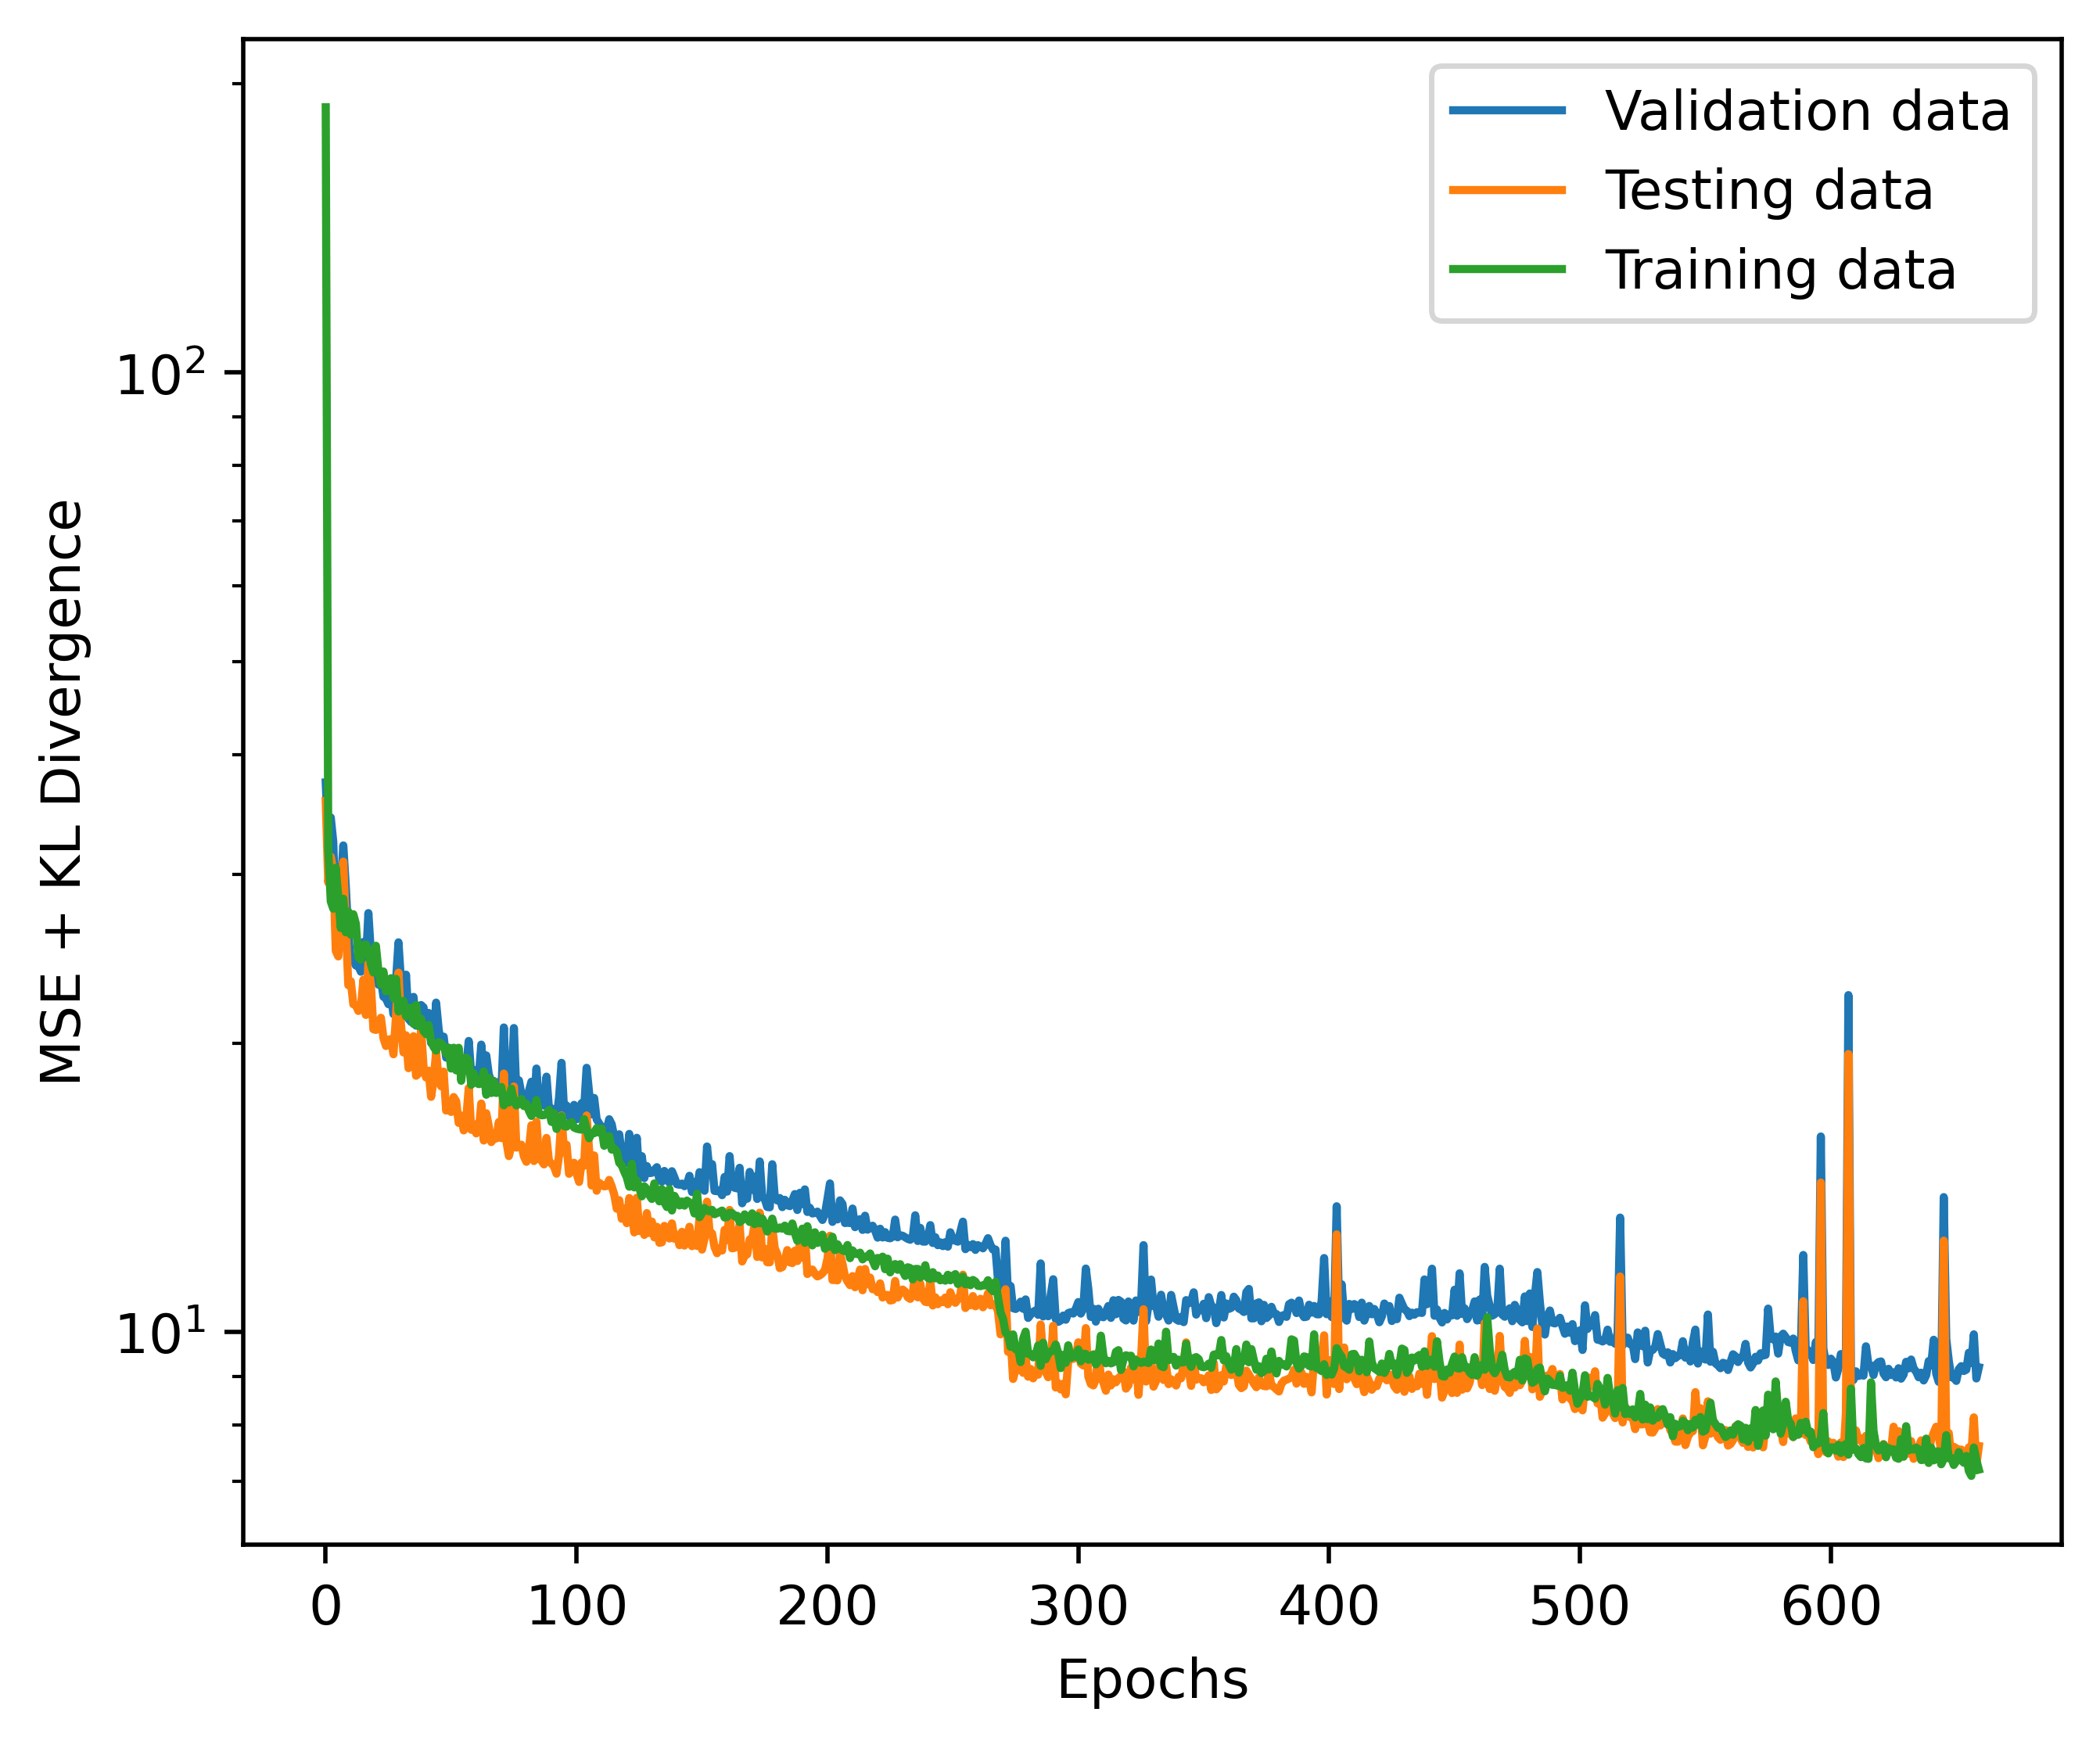

In [7]:
# plot and save the figure
save_path = pathlib.Path("../1.data-exploration/figures/tc_training_curve.png")

plt.figure(figsize=(6, 5), dpi=500)
plt.plot(val_loss_history, label="Validation data")
plt.plot(test_loss_history, label="Testing data")
plt.plot(train_loss_history, label="Training data")
plt.yscale("log")
plt.ylabel("MSE + KL Divergence")
plt.xlabel("Epochs")
plt.legend()
plt.savefig(save_path)
plt.show()

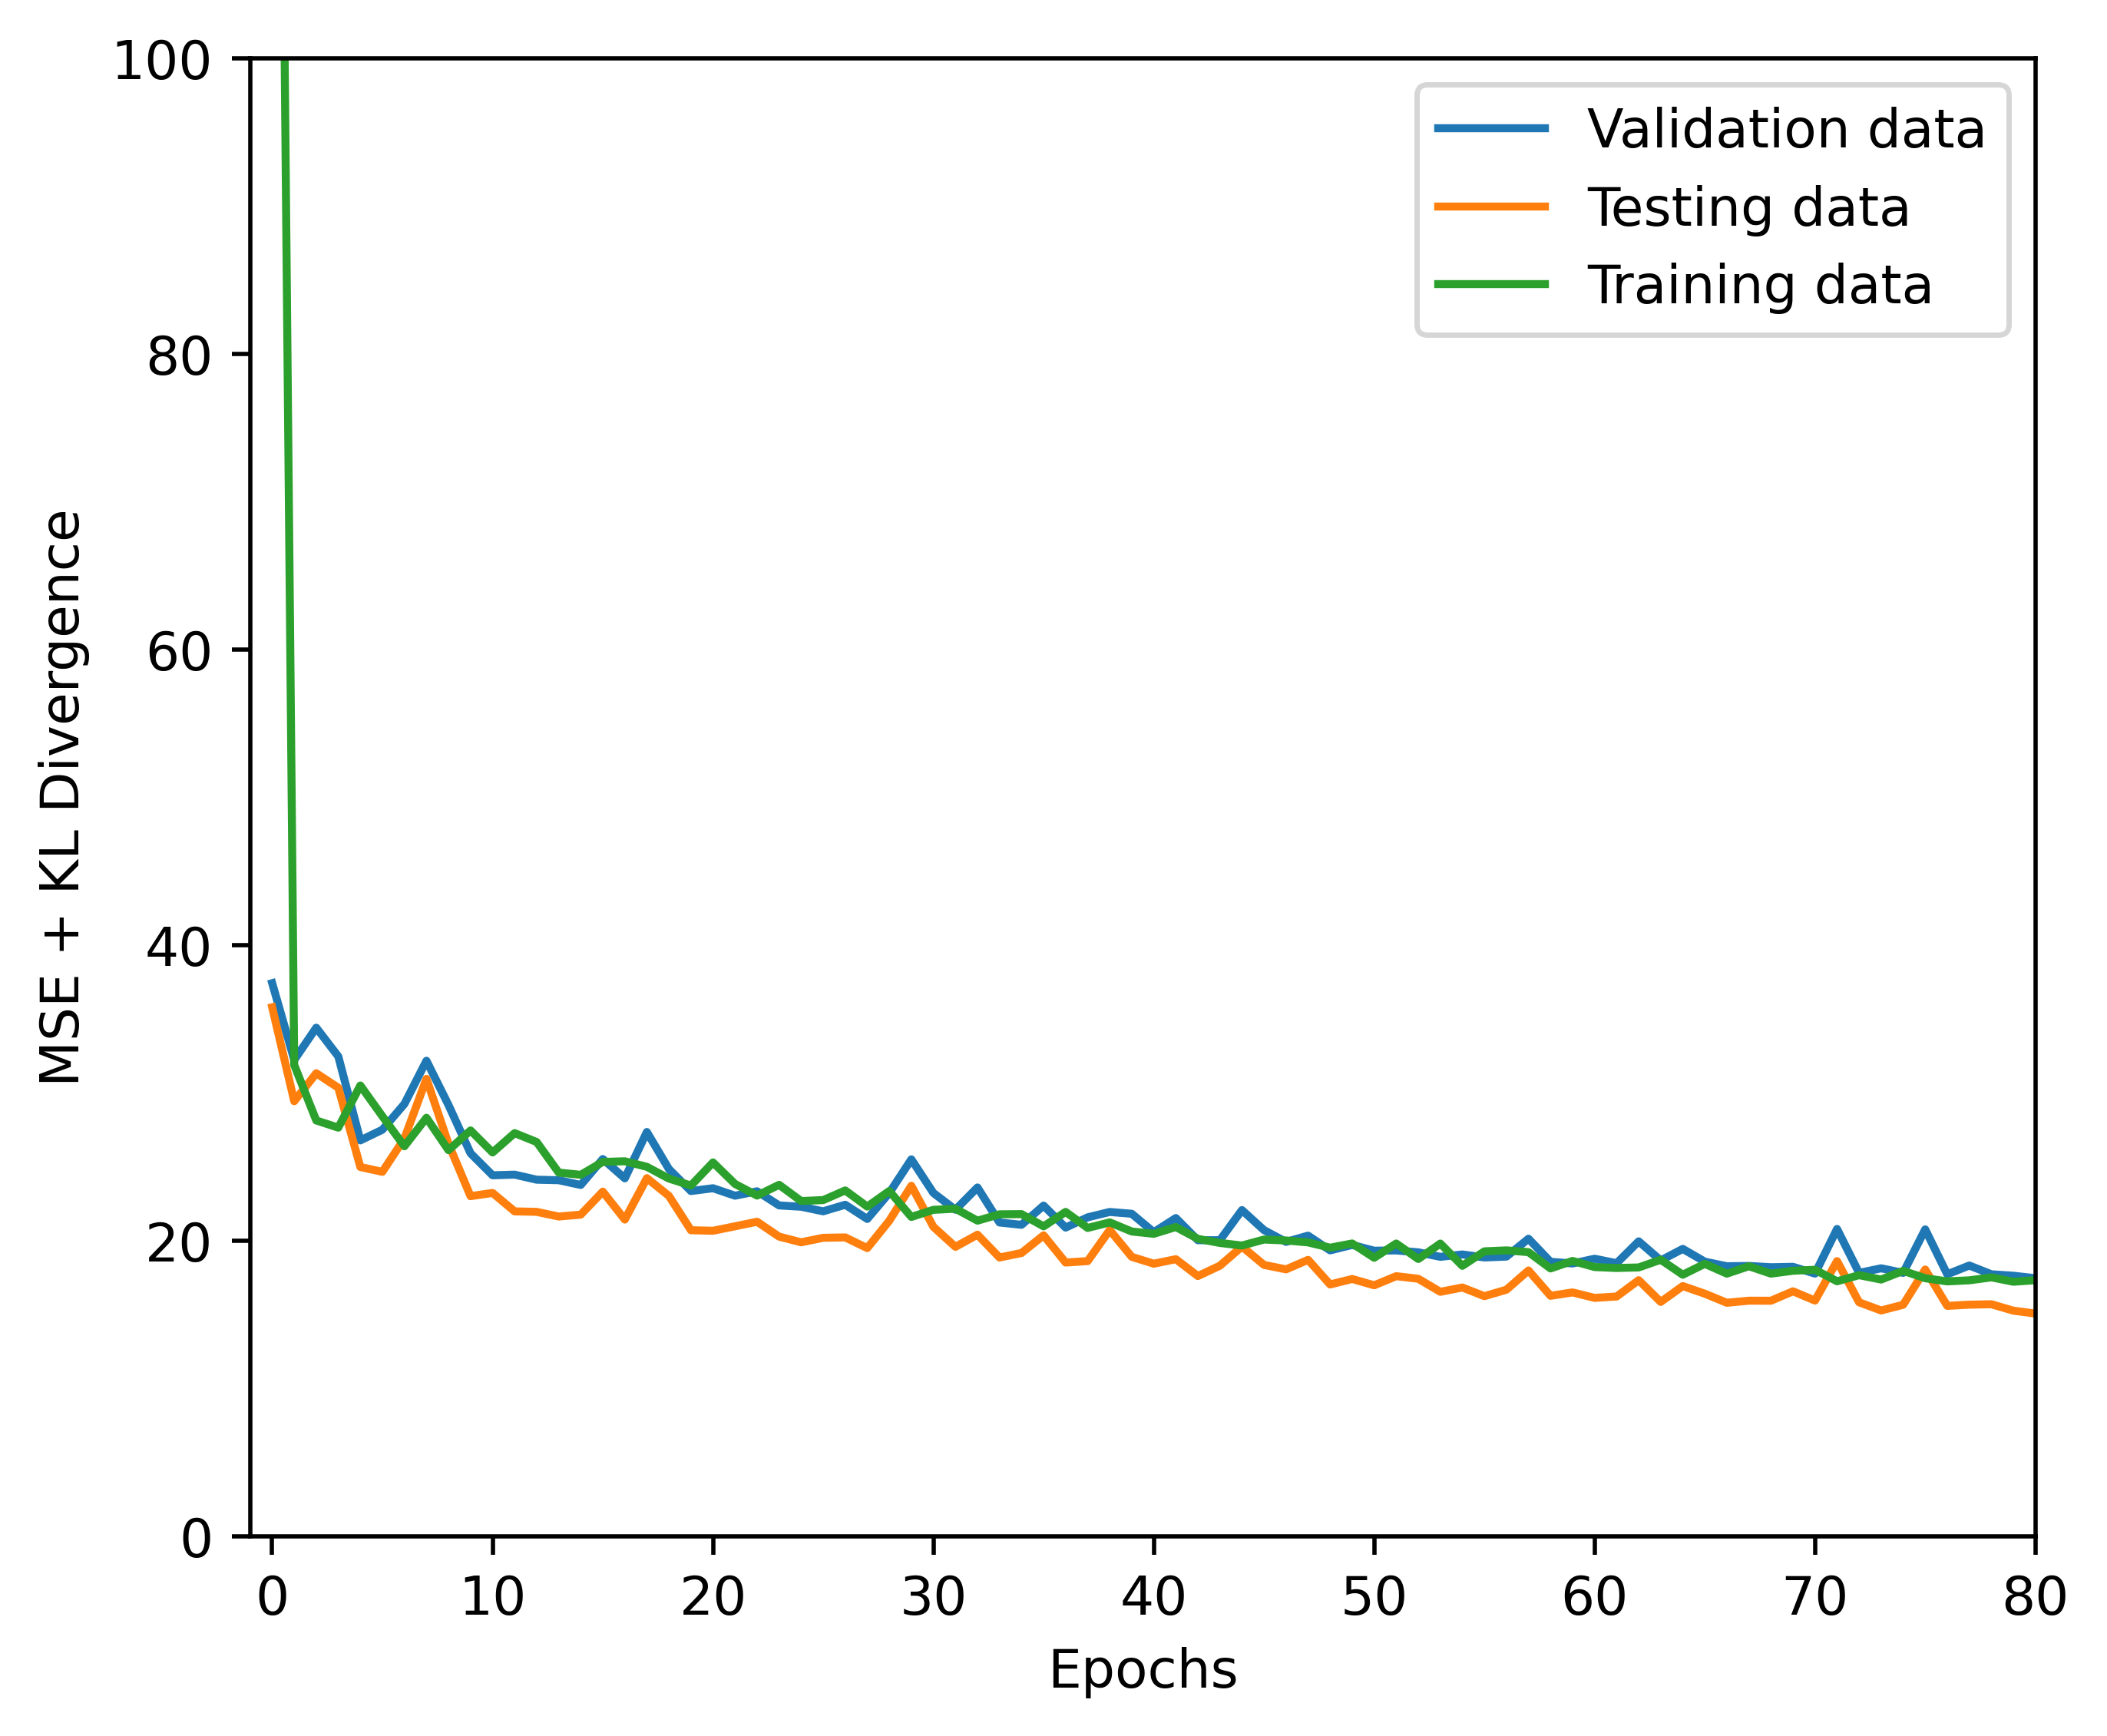

In [8]:
save_path = pathlib.Path("../1.data-exploration/figures/tc_training_curve_elbow.png")

plt.figure(figsize=(6, 5), dpi=500)
plt.xlim(-1,80)
plt.ylim(0,100)
plt.plot(val_loss_history, label="Validation data")
plt.plot(test_loss_history, label="Testing data")
plt.plot(train_loss_history, label="Training data")
plt.ylabel("MSE + KL Divergence")
plt.xlabel("Epochs")
plt.legend()
plt.savefig(save_path)
plt.show()

In [9]:
# Load data
data_directory = pathlib.Path("../0.data-download/data").resolve()
train_df = load_train_test_data(
    data_directory, train_or_test="train", drop_columns=False
)

train_df[["AgeCategory", "Sex"]] = train_df.age_and_sex.str.split(
    pat="_", expand=True
)

# create dataframe containing the genes that passed an initial QC (see Pan et al. 2022) and their corresponding gene label and extract the gene labels
gene_dict_df = pd.read_parquet(
    "../0.data-download/data/CRISPR_gene_dictionary.parquet"
)
gene_list_passed_qc = gene_dict_df.loc[
    gene_dict_df["qc_pass"], "dependency_column"
].tolist()

#Extract and process weights 
path = "./results/weight_matrix_gsea_tc.parquet"
train_data = train_df.filter(gene_list_passed_qc, axis=1)
final_gene_weights_df = tc_weights(model, train_data, path)

In [10]:
# Extract the latent space dimensions
metadata_df_dir = pathlib.Path("../0.data-download/data/metadata_df.parquet")
metadata = pd.read_parquet(metadata_df_dir)

train_and_test_subbed_dir = pathlib.Path("../0.data-download/data/train_and_test_subbed.parquet")
train_and_test_subbed = pd.read_parquet(train_and_test_subbed_dir)


# Convert DataFrame to NumPy and then Tensor
train_test_array = train_and_test_subbed.to_numpy()
train_test_tensor = torch.tensor(train_test_array, dtype=torch.float32)

#Create TensorDataset and DataLoader
tensor_dataset = TensorDataset(train_test_tensor)
train_and_test_subbed_loader = DataLoader(tensor_dataset, batch_size=32, shuffle=False)

path = "./results/tc_latent_df.parquet"

latent_df = extract_latent_dimensions(model, train_and_test_subbed_loader, metadata, path)
print(latent_df.head())

      ModelID         0         1         2         3         4         5  \
0  ACH-000499 -0.056191 -0.023820  0.031708 -0.070235  0.016751 -0.095499   
1  ACH-001668 -0.085990 -0.025145  0.022300 -0.073671  0.026289 -0.095721   
2  ACH-001211 -0.061487 -0.024206  0.028426 -0.089979  0.032904 -0.104289   
3  ACH-000997 -0.045133 -0.031905  0.030069 -0.085929  0.005808 -0.089941   
4  ACH-001745 -0.074096 -0.048792  0.026778 -0.074208  0.030538 -0.111752   

          6         7         8  ...       190       191       192       193  \
0 -0.031487 -0.076780 -0.048659  ...  0.021797  0.127212 -0.013655  0.107201   
1  0.019120 -0.077416 -0.036195  ...  0.015149  0.082278 -0.021855  0.118598   
2  0.010921 -0.072776 -0.023066  ...  0.030946  0.106697 -0.024308  0.111821   
3 -0.033448 -0.092271 -0.058259  ...  0.006775  0.136881 -0.025327  0.108986   
4  0.024760 -0.058889 -0.032025  ...  0.019256  0.086081 -0.004601  0.097182   

        194       195       196       197       198     